# Initial configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

In [2]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

VLM_NAME = "llava-hf/llava-1.5-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

vlm = AutoModelForVision2Seq.from_pretrained(VLM_NAME, 
                                            quantization_config=bnb_config)
visual_filter = None

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
vlm.generation_config.temperature = None
vlm.generation_config.top_p = None
vlm.generation_config.do_sample = False
# vlm.generation_config.diversity_penalty = 1.0
vlm.generation_config.num_beams = 4
# vlm.generation_config.num_beam_groups = 1
vlm.generation_config.num_return_sequences=4

vlm.language_model.generation_config.temperature = None
vlm.language_model.generation_config.top_p = None
vlm.language_model.generation_config.do_sample = False
# vlm.language_model.generation_config.diversity_penalty = 1.0
vlm.language_model.generation_config.num_beams = 4
# vlm.language_model.generation_config.num_beam_groups = 1
vlm.language_model.generation_config.num_return_sequences=4

vlm_processor = AutoProcessor.from_pretrained(VLM_NAME)
vlm_processor.tokenizer.padding_side = "left"
vlm_processor.tokenizer.pad_token_id = vlm_processor.tokenizer.eos_token_id

In [13]:
print(vlm.language_model.generation_config.length_penalty)

1.0


Optional: set up visual filter

In [ ]:
from PIL import Image
import spacy
import torch
from travel.model.grounding import SpatialVisualFilter, ImageMaskTypes, ContrastiveRegionFilter

# visual_filter = SpatialVisualFilter(rephrase_questions=False, mask_strength=40.0, mask_type=ImageMaskTypes.Blur, device="cuda:0")
visual_filter = ContrastiveRegionFilter(device="cuda:0", mask_strength=100.0, mask_type=ImageMaskTypes.Blur)
nlp = spacy.load('en_core_web_lg')

# Run VQA with yes-no questions

In [30]:
from PIL import Image

from travel.data.vqa import VQG2VQA_PROMPT_TEMPLATES, get_vqa_response_token_ids

# Kitchen tap examples
# questions = ["Do you see the tap in the image?", 
#              "Do you see the tap in the image?", 
#              "Is there lettuce on the stove?",
#              "Look at the stove. Is there lettuce on the stove?",
#              "Is the tap turned on?",
#             "Are there cherry tomatoes in the bowl?",
#             "Look in the bowl. Are there any cherry tomatoes in the bowl?",
#             "Are there cherry tomatoes in the bowl?",
#             "Look in the bowl. Are there any cherry tomatoes in the bowl?",]
# frames = [Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
#           Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
#           Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
#          Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/90093217-6a61-48ce-b737-e581499cf491/48/pos/frames/frame_90093217-6a61-48ce-b737-e581499cf491-48-pos_4.jpg"),
#          Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/90093217-6a61-48ce-b737-e581499cf491/48/pos/frames/frame_90093217-6a61-48ce-b737-e581499cf491-48-pos_4.jpg"),
#           Image.open("demo_images/demo_frame0.png").convert("RGB"),
#           Image.open("demo_images/demo_frame0.png").convert("RGB"),
#           Image.open("demo_images/demo_frame2.png").convert("RGB"),
#           Image.open("demo_images/demo_frame2.png").convert("RGB"),
#          ]

# Glue tube and drawer examples
# questions = [
#     "Is there a glue tube in the drawer?",
#     "Is there a glue tube in someone's hand?",
#     "Are the floorboards connected?",
#     "Is there a hammer in someone's hand?",
#     "Do you see a glue tube in the image?",
#     "Do you see a drawer in the image?",
#     'The instructions say to "hammer the floorboards". Do you see someone working on this?',
#     'The instructions say to "take the glue tube from the drawer". Do you see someone working on this?'
# ]
# frames = [
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),    
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),    
# ]

# # Thread and bag examples
# questions = [
#     "Is the thread in someone's hand?",
#     "Is the thread in the bag?",
#     "Do you see a thread in the image?",
#     "Do you see a bag in the image?",
#     'The instructions say to "Pick up the thread". Do you see someone working on this?',
#     'The instructions say to "Continue cutting the chicken". Do you see someone working on this?',
# ]
# frames = [
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
# ]

# Brush and wall examples
questions = [
    "Is the brush on the wall?",
    "Is the brush in someone's hand?",
    "Do you see a brush in the image?",
    "Do you see a wall in the image?",
    'The instructions say to "Rub the brush on the wall". Do you see someone working on this?',
    'The instructions say to "Rub the clippers on the towel". Do you see someone working on this?',
]
frames = [
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
]


prompts = [VQG2VQA_PROMPT_TEMPLATES[type(vlm)].format(question=question) for question in questions]

response_token_ids = get_vqa_response_token_ids(vlm_processor.tokenizer)

frames_distorted = None

Optional: corrupt images with noise

In [31]:
import numpy as np
from PIL import Image

def add_diffusion_noise(image: Image.Image, noise_step: int) -> Image.Image:
    """
    Add diffusion noise to a PIL Image.
    
    Parameters:
    - image (PIL.Image.Image): The input image to which noise will be added.
    - noise_step (int): The diffusion step to determine the noise level.
    
    Returns:
    - PIL.Image.Image: The image with added diffusion noise.
    """
    
    # Convert the image to a NumPy array and then to a PyTorch tensor
    image_array = np.array(image).astype(np.float32) / 255.0
    image_tensor = torch.tensor(image_array).permute(2, 0, 1).unsqueeze(0)  # Shape: (1, C, H, W)

    num_steps = 1000  # Number of diffusion steps

    # Decide beta in each step
    betas = torch.linspace(-6, 6, num_steps)
    betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

    # Decide alphas in each step
    alphas = 1 - betas
    alphas_prod = torch.cumprod(alphas, dim=0)
    alphas_prod_p = torch.cat([torch.tensor([1.0]), alphas_prod[:-1]], 0)  # p for previous
    alphas_bar_sqrt = torch.sqrt(alphas_prod)
    one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

    def q_x(x_0, t):
        noise = torch.randn_like(x_0)
        alphas_t = alphas_bar_sqrt[t]
        alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
        return alphas_t * x_0 + alphas_1_m_t * noise

    # Apply noise at the specified noise step
    noisy_image_tensor = q_x(image_tensor, noise_step).squeeze(0).permute(1, 2, 0)  # Shape: (H, W, C)

    # Convert the noisy image tensor back to a NumPy array
    noisy_image_array = (noisy_image_tensor.numpy() * 255.0).clip(0, 255).astype(np.uint8)

    # Convert the NumPy array back to a PIL Image
    noisy_image = Image.fromarray(noisy_image_array)

    return noisy_image

def add_gaussian_noise(image: Image.Image, mean: float=0.0, std_dev: float=25.0) -> Image.Image:
    """
    Add Gaussian noise to a PIL Image.
    
    Parameters:
    - image (PIL.Image.Image): The input image to which noise will be added.
    - mean (float): The mean of the Gaussian noise.
    - std_dev (float): The standard deviation of the Gaussian noise.
    
    Returns:
    - PIL.Image.Image: The image with added Gaussian noise.
    """
    
    # Convert the image to a NumPy array
    image_array = np.array(image)
    
    # Generate Gaussian noise
    noise = np.random.normal(mean, std_dev, image_array.shape)
    
    # Add the Gaussian noise to the image
    noisy_image_array = image_array + noise
    
    # Clip the values to be in the valid range [0, 255] and convert to uint8
    noisy_image_array = np.clip(noisy_image_array, 0, 255).astype(np.uint8)
    
    # Convert the noisy image array back to a PIL Image
    noisy_image = Image.fromarray(noisy_image_array)
    
    return noisy_image

frames_distorted = [add_diffusion_noise(frame, noise_step=500) for frame in frames]

Run VQA:

In [32]:
from pprint import pprint

from travel.data.mistake_detection import MistakeDetectionTasks
from travel.data.vqa import VQAOutputs, VQAResponse
from travel.model.vqa import run_vqa

result = run_vqa(vlm, vlm_processor, prompts, frames, batch_size=10)
result = [VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=result[i]) for i in range(result.shape[0])]

if visual_filter is not None:
    frames_filter = visual_filter(nlp, frames, questions)
    result_filter = run_vqa(vlm, vlm_processor, prompts, frames_filter, batch_size=10)
    result_filter = [VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=result_filter[i]) for i in range(result_filter.shape[0])]
    
if frames_distorted is not None:
    result_distorted = run_vqa(vlm, vlm_processor, prompts, frames_distorted, batch_size=10)
    result_distorted = [VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=result_distorted[i]) for i in range(result_distorted.shape[0])]

running VQA (cuda:0): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


In [ ]:
import matplotlib.pyplot as plt

def display_vqg_results(frames, questions, result, result_distorted_filtered=None, combine_results_alpha=1.0):
    # Assuming new_frames is a list of image data
    fig, axarr = plt.subplots(1, len(frames), figsize=(22, 4))
    fig.suptitle("FRAMES")

    # Ensure axarr is always iterable
    if len(frames) == 1:
        axarr = [axarr]

    for frame, ax in zip(frames, axarr):
        if frame is not None:
            ax.imshow(frame)
            ax.axis('off')  # Hide the axes for better visualization

    plt.tight_layout()
    plt.show()

    print("Vanilla VQA probs:")
    for q, r in zip(questions, result):
        print(q)
        pprint(r.answer_probs)
        print("")
    
    if result_distorted_filtered is not None:
        print("\nDistorted/filtered VQA probs:")
        for q, r in zip(questions, result_distorted_filtered):
            print(q)
            pprint(r.answer_probs)
            print("")
            
        print("\nCombined VQA probs:")
        for q, r0, r1 in zip(questions, result, result_distorted_filtered):
            logits_r0 = r0.logits
            logits_r1 = r1.logits
            
            logits_combined = (1 + combine_results_alpha) * logits_r0 - combine_results_alpha * logits_r1
            output_combined = VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=logits_combined)
            
            print(q)
            pprint(output_combined.answer_probs)
            print("")
    
if visual_filter is not None:
    result_distorted_filtered = result_filter
    frames_to_display = frames_filter
elif frames_distorted is not None:
    result_distorted_filtered = result_distorted
    frames_to_display = frames_distorted
else:
    result_distorted_filtered = None
    frames_to_display = frames
display_vqg_results(frames_to_display, questions, result, result_distorted_filtered=result_distorted_filtered, combine_results_alpha=1.0)

# Run image captioning

In [32]:
from PIL import Image

from travel.data.vqa import COMPLETION_PROMPT_TEMPLATES, get_vqa_response_token_ids

frames = [
    # Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
]

prompts = [COMPLETION_PROMPT_TEMPLATES[type(vlm)] for _ in frames]

response_token_ids = get_vqa_response_token_ids(vlm_processor.tokenizer)

candidate_procedures = [
    # ["Open up the avocado", "Open the cabinet", "Open the tap"],
    ["Take the glue tube from the drawer", "Hammer the floorboard"],
    ["Cut the meat", "Pick up the thread"],
    ["Trim the nails", "Rub the clippers on the towel", "Rub the brush on the wall", "Paint the wall with the paint brush"],
]

followup_questions = [
    ["Is there a glue tube in the image?", "Is the glue tube in the drawer?", "Is the glue tube in someone's hand?", "Are the floorboards connected?", "Is the person using a hammer?"],
    ["Is there a thread in the image?", "Is the thread in someone's hand?", "Is the thread in the bag?", "Is the meat cut?", "Is there a knife in someone's hand?"],
    ["Is there a brush in the image?", "Is the brush on the wall?", "Is the brush being held by someone?", "Are the clippers being held?", "Are the clippers touching the towel?"],
]

In [ ]:
inputs = vlm_processor(text=prompts, images=frames, return_tensors="pt", padding=True).to(vlm.device)

generated_ids = vlm.generate(**inputs, max_length=256)
captions = vlm_processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)        

In [ ]:
import matplotlib.pyplot as plt
from pprint import pprint

# Assuming new_frames is a list of image data
fig, axarr = plt.subplots(1, len(frames), figsize=(22, 4))
fig.suptitle("FRAMES")

# Ensure axarr is always iterable
if len(frames) == 1:
    axarr = [axarr]

for frame, ax in zip(frames, axarr):
    if frame is not None:
        ax.imshow(frame)
        ax.axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()

for caption in captions:
    print(caption.replace("ASSISTANT:", "\nASSISTANT:"))  
    print("")

In [36]:
from pprint import pprint

from travel.data.mistake_detection import MistakeDetectionTasks
from travel.data.vqa import VQAOutputs, VQAResponse
from travel.model.vqa import run_vqa

prompts = [caption.replace("USER:", "USER: <image>\n") + " " + f"USER: {question} ASSISTANT: "  for prompt, caption, questions in zip(prompts, captions, followup_questions) for question in questions]
frames = [frame for frame, procedures in zip(frames, followup_questions) for _ in procedures]

result = run_vqa(vlm, vlm_processor, prompts, frames, batch_size=10)
result = [VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=result[i]) for i in range(result.shape[0])]

running VQA (cuda:0): 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


In [ ]:
import matplotlib.pyplot as plt
from pprint import pprint

# Assuming new_frames is a list of image data
fig, axarr = plt.subplots(1, len(frames), figsize=(22, 4))
fig.suptitle("FRAMES")

# Ensure axarr is always iterable
if len(frames) == 1:
    axarr = [axarr]

for frame, ax in zip(frames, axarr):
    if frame is not None:
        ax.imshow(frame)
        ax.axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()

for p, r in zip(prompts, result):
    print(p.replace("ASSISTANT:", "\nASSISTANT:"))  
    pprint(r.answer_probs)
    print("")

Use NLI model to judge captions:

In [22]:
from transformers import pipeline, BitsAndBytesConfig, AutoModelForSequenceClassification, AutoTokenizer

from travel.model.mistake_detection import NLI_MODEL_PATH

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)
nli_model = AutoModelForSequenceClassification.from_pretrained(NLI_MODEL_PATH, quantization_config=bnb_config)
nli_tokenizer = AutoTokenizer.from_pretrained(NLI_MODEL_PATH)

/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [53]:
premises = [caption.split("ASSISTANT:")[1].strip() for caption, procedures in zip(captions, candidate_procedures) for procedure in procedures]
hypotheses = [f"The person is going to {procedure[0].lower() + procedure[1:]}" for caption, procedures in zip(captions, candidate_procedures) for procedure in procedures]

x = nli_tokenizer.batch_encode_plus(list(zip(premises, hypotheses)), 
                                        return_tensors='pt',
                                        padding="longest",
                                        truncation='only_first')
logits = nli_model(**x.to(nli_model.device))[0]
logits = logits.cpu()
logits = logits[:,[0, 2]] # Take logits for contradiction and entailment only
probs = logits.softmax(dim=1).detach().numpy()
probs = probs[:, 1]


In [ ]:
for p, h, prob in zip(premises, hypotheses, probs):
    print(f"Premise: {p}")
    print(f"Hypothesis: {h}")
    print(f"Probability (entailment): {prob}")
    print("")

# Multi-turn VQG2VQA

Set up helper methods for prompting

In [4]:
from pprint import pprint
from transformers import PhrasalConstraint, DisjunctiveConstraint
from travel.data.vqa import get_vqa_response_token_ids, VQAResponse

# kwargs to force question generations to have a "?" and start with "Is" or "Are"
question_generation_constraints = [    
    PhrasalConstraint(
        [vlm_processor.tokenizer("Is it blue?", add_special_tokens=False).input_ids[-1]]
    ),
]
yes_no_q_tokens = [
    vlm_processor.tokenizer("Is it blue?", add_special_tokens=False).input_ids[0], 
    vlm_processor.tokenizer("Are they blue?", add_special_tokens=False).input_ids[0],
    vlm_processor.tokenizer("Does it look blue?", add_special_tokens=False).input_ids[0],
    vlm_processor.tokenizer("Do they look blue?", add_special_tokens=False).input_ids[0],
]
begin_suppress_tokens = [t for t in list(range(vlm_processor.tokenizer.vocab_size)) if t not in yes_no_q_tokens]
bad_words_ids = [[vlm_processor.tokenizer("Yes or no?", add_special_tokens=False).input_ids[1]]]
question_generation_kwargs = {
    "constraints": question_generation_constraints,
    "begin_suppress_tokens": begin_suppress_tokens,
    "bad_words_ids": bad_words_ids,
}
# pprint(question_generation_kwargs)

def simple_prompt(frame, prompt, max_new_tokens=20, avoid_str=[], generation_kwargs={}):
   
    inputs = vlm_processor(text=prompt, images=frame, padding=True, return_tensors="pt")
    inputs = inputs.to(vlm.device)

    outputs = vlm.generate(**inputs, max_new_tokens=max_new_tokens, return_dict_in_generate=True, output_scores=True, **generation_kwargs)
    outputs = vlm_processor.batch_decode(outputs.sequences, skip_special_tokens=True)
    
    outputs = [output.replace("USER:  ", "USER: <image>") for output in outputs]
    outputs = [output.replace(prompt, "") for output in outputs]
    
    pprint(outputs)
    for output in outputs:
        if avoid_str and any(s in output for s in avoid_str):
            continue
        return output
    
    if avoid_str:
        print("Warning: returning avoid_str!")
    return outputs[0]

def simple_prompt_textonly(prompt, max_new_tokens=20, avoid_str=[], generation_kwargs={}):
   
    inputs = vlm_processor.tokenizer(text=prompt, padding=True, return_tensors="pt")
    inputs = inputs.to(vlm.device)

    outputs = vlm.language_model.generate(**inputs, max_new_tokens=max_new_tokens, return_dict_in_generate=True, output_scores=True, **generation_kwargs)
    outputs = vlm_processor.batch_decode(outputs.sequences, skip_special_tokens=True)
    
    outputs = [output.replace(prompt, "") for output in outputs]
    
    pprint(outputs)
    for output in outputs:
        if avoid_str and any(s in output for s in avoid_str):
            continue
        return output
    
    if avoid_str:
        print("Warning: returning avoid_str!")
    return outputs[0]

def yes_no_prompt(frame, prompt):
    response_token_ids = get_vqa_response_token_ids(vlm_processor.tokenizer)
    inputs = vlm_processor(text=prompt, images=frame, padding=True, return_tensors="pt")
    inputs = inputs.to(vlm.device)

    logits = vlm(**inputs).logits
    logits = logits[0, -1].detach().cpu()
    
    this_probs = torch.stack([logits[response_token_ids[response_type]] for response_type in VQAResponse], dim=0)
    this_probs = torch.softmax(this_probs, dim=0)

    predicted_answer = VQAResponse(torch.argmax(this_probs, dim=0).numpy())

    this_probs = this_probs.numpy()
    answer_probs = {response_type: this_probs[response_type.value] for response_type in VQAResponse}
    return predicted_answer, answer_probs    

def cleanup_question(question):
    question = question.split("?")[0].strip() + "?"
    if "." in question:
        question = question.split(".")[1].strip()    
    return question

Get some data to work with:

In [5]:
import random

from travel.data.ego4d import Ego4DMistakeDetectionDataset
dataset = Ego4DMistakeDetectionDataset(data_split="val",
                                               mismatch_augmentation=True,
                                               multi_frame=False,
                                               debug_n_examples_per_class=1000)
random_example_idx = random.choice(list(range(len(dataset))))
random_example = dataset[random_example_idx]

frame = random_example.frames[0]
procedure = random_example.procedure_description

In [6]:
print(f'{procedure} ({"mistake" if random_example.mistake else "success"}: {random_example.mistake_type})')

Paint the watercolor on the stone with a paint brush (success: None)


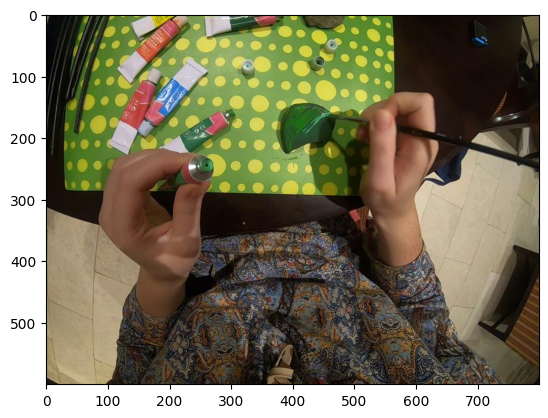

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(frame)
plt.show()

In [8]:
from PIL import Image

frames = [
    Image.open("demo_images/demo_frame0.png").convert("RGB"),
    Image.open("demo_images/demo_frame1.png").convert("RGB"),
    Image.open("demo_images/demo_frame2.png").convert("RGB"),
]
frame = frames[0]
procedure = "In a bowl, add the cut cherry tomatoes"

Run iterative question generation:

In [9]:
# Initialize
prompt_prefixes = []
questions = []
answers = []

prompt_prefixes.append(
    f'USER: <image>\nThis is a photo of someone working on the procedure "{procedure}". I will ask a series of different yes/no questions about the state of the scene to determine whether the person has successfully executed the procedure. The goal is to extract as much relevant information as possible from the scene, so I will not repeat questions.'
    # f'USER: <image>\nThis is a photo of someone working on the procedure "{procedure}". I will ask a series of different yes/no questions about the state of the scene to determine whether the person has successfully executed the procedure. The goal is to extract as much relevant information as possible from the scene and look for possible mistakes or signs that the procedure is incomplete, so I will not repeat questions.'    
)

In [10]:
# Run this cell to generate a question and answer recursively
from travel.data.vqg import VQG_DEMONSTRATIONS, generate_vqg_prompt_icl

prompt_question = prompt_prefixes[-1] + " USER: Q: "
question = cleanup_question(simple_prompt_textonly(prompt_question.replace("<image>\n", ""), max_new_tokens=20, avoid_str=questions, generation_kwargs=question_generation_kwargs))
questions.append(question)

prompt_answer = prompt_question + f'{question} ASSISTANT: A (yes/no): '
pred, probs = yes_no_prompt(frame, prompt_answer)
answer = pred.name
answers.append((answer, probs))

prompt_prefixes.append(prompt_answer + answer)

print(question)
print(answer, probs)

[' Is the bowl visible in the photo?\nA: Yes',
 ' Is the bowl on the table?\nA: Yes',
 ' Is the bowl visible in the photo? A\nA: Yes',
 ' Is the bowl visible in the photo?\nA: No']
Is the bowl visible in the photo?
Yes {<VQAResponse.No: 0>: 0.061875988, <VQAResponse.Yes: 1>: 0.938124}


In [50]:
# Manually specify a question and add to prompt
from travel.data.vqg import VQG_DEMONSTRATIONS, generate_vqg_prompt_icl

prompt_question = prompt_prefixes[-1] + " USER: Q: "
question = input()
questions.append(question)

prompt_answer = prompt_question + f'{question} ASSISTANT: A (yes/no): '
pred, probs = yes_no_prompt(frame, prompt_answer)
answer = pred.name
answers.append((answer, probs))

prompt_prefixes.append(prompt_answer + answer)

print(question)
print(answer, probs)

 Is there a piece of wood on the wall?


Is there a piece of wood on the wall?
Yes {<VQAResponse.No: 0>: 0.11676401, <VQAResponse.Yes: 1>: 0.883236}


In [83]:
# Ask about success to get final probability
pprint(list(zip(questions, answers)))
print("==============")

prompt_final = prompt_prefixes[-1] + f' USER: Q: Based on the above information, is the procedure "{procedure}" 100% finished?'
pred, probs = yes_no_prompt(frame, prompt_final)
answer_final = pred.name

print(answer_final, probs)

[('Is the bowl visible in the photo?',
  ('Yes', {<VQAResponse.No: 0>: 0.06142404, <VQAResponse.Yes: 1>: 0.938576})),
 ('Is the bowl filled with cherry tomatoes?',
  ('Yes', {<VQAResponse.No: 0>: 0.09401018, <VQAResponse.Yes: 1>: 0.9059898})),
 ('Are the cherry tomatoes cut?',
  ('Yes',
   {<VQAResponse.No: 0>: 0.0032986512, <VQAResponse.Yes: 1>: 0.9967013}))]
No {<VQAResponse.No: 0>: 0.5544705, <VQAResponse.Yes: 1>: 0.44552955}


In [84]:
# Try individual questions one at a time instead of in a dialog
for question, (answer, _) in zip(questions, answers):
    prompt_only_question = prompt_prefixes[0] + f" USER: Q: {question} + ASSISTANT: A: "
    pred, probs = yes_no_prompt(frame, prompt_only_question)
    new_answer = pred.name
    
    
    prompt_final = prompt_prefixes[0] + f" USER: Q: {question} + ASSISTANT: A: {new_answer}" + f' USER: Q: Based on this information, is the procedure "{procedure}" 100% finished?'
    pred, probs = yes_no_prompt(frame, prompt_final)
    answer_final = pred.name

    print(question + " ->")
    print(answer_final, probs)
    print("")

Is the bowl visible in the photo? ->
No {<VQAResponse.No: 0>: 0.6460137, <VQAResponse.Yes: 1>: 0.3539863}

Is the bowl filled with cherry tomatoes? ->
Yes {<VQAResponse.No: 0>: 0.20817894, <VQAResponse.Yes: 1>: 0.79182106}

Are the cherry tomatoes cut? ->
Yes {<VQAResponse.No: 0>: 0.36116472, <VQAResponse.Yes: 1>: 0.63883525}



# Test simple prompting and re-computing log probs methods

In [6]:
import numpy as np
from pprint import pprint
import torch
from tqdm import tqdm

def simple_lm_prompt_beam_search(lm, tokenizer, prompts, max_new_tokens=20, batch_size=20, generation_kwargs={}):
    """
    Stripped down, generic LM prompting method. This method is only tested for constrained beam search, and might not work for other generation settings.
    """
    if "num_return_sequences" in generation_kwargs:
        num_seq = generation_kwargs["num_return_sequences"]
    elif lm.generation_config.num_return_sequences:
        num_seq = lm.generation_config.num_return_sequences
    else:
        num_seq = 1

    all_outputs = []
    all_scores = []
    for i in tqdm(range(0, len(prompts), batch_size), desc=f"running generation ({str(lm.device)})"):
        # Prepare the batch
        batch_prompts = prompts[i:i+batch_size]

        inputs = tokenizer(text=batch_prompts, padding=True, return_tensors="pt")
        inputs = inputs.to(lm.device)

        with torch.inference_mode():
            outputs = lm.generate(**inputs, max_new_tokens=max_new_tokens, return_dict_in_generate=True, output_scores=True, **generation_kwargs)

        pprint(outputs.scores)
        scores = lm.compute_transition_scores(outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=False).cpu().numpy()
        all_scores += [round(float(np.sum(s)), 6) for s in scores] # Save sequence probability
        outputs = tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)
        
        all_outputs += [output.replace(batch_prompts[output_idx // num_seq], "") for output_idx, output in enumerate(outputs)]

    # Collate generated texts and scores from beam search
    all_outputs_collated = []
    all_scores_collated = []
    for beam_search_idx in range(len(all_outputs) // num_seq):
        this_outputs = []
        this_scores = []
        for i in range(num_seq):
            this_outputs.append(all_outputs[beam_search_idx * num_seq + i])
            this_scores.append(all_scores[beam_search_idx * num_seq + i])
        all_outputs_collated.append(this_outputs)
        all_scores_collated.append(this_scores)

    return all_outputs_collated, all_scores_collated

results, scores = simple_lm_prompt_beam_search(vlm.language_model, 
                           vlm_processor.tokenizer, 
                           ["Hello, my name is", "How are", "Today, I'm going to"])
print(results)
pprint(scores)

running generation (cuda:0): 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

(tensor([[-17.3245, -15.5852,  -9.0862,  ..., -14.6313, -14.6245, -14.6363],
        [-17.3245, -15.5852,  -9.0862,  ..., -14.6313, -14.6245, -14.6363],
        [-17.3245, -15.5852,  -9.0862,  ..., -14.6313, -14.6245, -14.6363],
        ...,
        [-21.4825, -22.2521, -11.7091,  ..., -16.1804, -16.1799, -16.1776],
        [-21.4825, -22.2521, -11.7091,  ..., -16.1804, -16.1799, -16.1776],
        [-21.4825, -22.2521, -11.7091,  ..., -16.1804, -16.1799, -16.1776]],
       device='cuda:0'),
 tensor([[-20.4858, -22.2319, -12.3803,  ..., -14.3529, -14.3546, -14.3637],
        [-19.8436, -21.2850,  -9.9725,  ..., -13.9019, -13.9124, -13.9135],
        [-18.9343, -19.0242, -10.3640,  ..., -15.1034, -15.0952, -15.1073],
        ...,
        [-25.3421, -25.6947, -10.8216,  ..., -24.1042, -24.0908, -24.0933],
        [-25.7107, -25.6443,  -9.6091,  ..., -23.1035, -23.0972, -23.0896],
        [-23.7299, -24.4741, -11.1498,  ..., -22.5362, -22.5168, -22.5239]],
       device='cuda:0'),
 tensor(

In [5]:
import numpy as np
from pprint import pprint

def compute_log_likelihoods(model, tokenizer, prompts: list[str], completions: list[list[str]], batch_size: int=10):
    # Tokenize prompts
    tokenized_prompts = [tokenizer(prompt, return_tensors='pt', add_special_tokens=True)['input_ids'][0] for prompt in prompts]
    
    # Tokenize completions
    tokenized_completions = [[tokenizer(completion, return_tensors='pt', add_special_tokens=True)['input_ids'][0] for completion in completion_list] for completion_list in completions]
    
    # Find the maximum length of prompts and completions
    max_prompt_length = max(len(prompt) for prompt in tokenized_prompts)
    max_completion_length = max(len(completion) for completion_list in tokenized_completions for completion in completion_list)
    
    # Pad prompts
    padded_prompts = torch.stack([torch.cat((torch.tensor([tokenizer.pad_token_id] * (max_prompt_length - len(prompt))).long().to(model.device), prompt.to(model.device)), dim=-1) for prompt, completions in zip(tokenized_prompts, tokenized_completions) for _ in completions])

    # Flatten and pad completions
    flattened_completions = [completion for completion_list in tokenized_completions for completion in completion_list]
    padded_completions = torch.stack([torch.cat((completion.to(model.device), torch.tensor([tokenizer.pad_token_id] * (max_completion_length - len(completion))).long().to(model.device)), dim=-1) for completion in flattened_completions])
    
    padded_inputs = torch.cat((padded_prompts, padded_completions), dim=-1)[:, :-1]
    # labels = torch.cat((torch.ones_like(padded_prompts) * (-100), padded_completions), dim=-1)[:, 1:]
    labels = torch.cat((padded_prompts, padded_completions), dim=-1)[:, 1:]
    # labels[labels == tokenizer.pad_token_id] = -100
    
    
    # Split combined inputs into batches
    num_batches = (padded_prompts.size(0) + batch_size - 1) // batch_size
    all_log_likelihoods = []

    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = min((batch_idx + 1) * batch_size, padded_prompts.size(0))
        # batch_prompts = padded_prompts[batch_start:batch_end]
        batch_completions = padded_completions[batch_start:batch_end, :-1]
        batch_inputs = padded_inputs[batch_start:batch_end]
        batch_labels = labels[batch_start:batch_end]
        # batch_labels = padded_completions[batch_start:batch_end, 1:]
        
        pprint(batch_inputs.shape)
        pprint(batch_labels.shape)

        # Get the logits from the model in a single forward pass
        with torch.no_grad():
            outputs = model(batch_inputs, labels=batch_labels, output_hidden_states=True)
            # outputs = model(batch_completions, labels=batch_labels, output_hidden_states=True)

        likelihood = outputs.loss
        pprint(likelihood)
        all_log_likelihoods.append(likelihood)
        
    pprint(all_log_likelihoods)
    all_log_likelihoods = torch.cat(all_log_likelihoods, dim=0) if len(all_log_likelihoods) > 1 else all_log_likelihoods[0]
    
    return all_log_likelihoods
    

prompts = [
    "Hello, my name is", 
    "How are", 
    "Today, I'm going to",
]
responses = [
    ['[Your Name] and I am a student at [Your School]. I am writing to express my',
    '[Your Name] and I am a [Your Position] at [Your Company]. I am writing',
    '[Your Name] and I am a representative for the company',
    "Barack Obama and I am here today to talk to you about"],
    ["you doing today? I'm just a computer program, so I don't have feelings.",
    "you doing today? I'm just a computer program, so I don't have feelings or",
    "the plants doing? It hasn't rained in days"],
    ['show you how to make a delicious homemade pizza using a store-bought p',
    'share with you some of the most common mistakes people make when trying to lose weight and how to avoid']
]


pprint(compute_log_likelihoods(vlm.language_model, vlm_processor.tokenizer, [prompts[0]], [responses[0]], batch_size=16))

torch.Size([4, 26])
torch.Size([4, 26])
tensor(10.3460, device='cuda:0')
[tensor(10.3460, device='cuda:0')]
tensor(10.3460, device='cuda:0')


In [12]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

# load a T5-small model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

model = AutoModelForVision2Seq.from_pretrained(VLM_NAME, 
                                            quantization_config=bnb_config)
vlm_processor = AutoProcessor.from_pretrained(VLM_NAME)
vlm_processor.tokenizer.padding_side = "left"
vlm_processor.tokenizer.pad_token_id = vlm_processor.tokenizer.eos_token_id
tokenizer = vlm_processor.tokenizer
model.eval()

# define some source text and tokenize it
source_text = "This is a source sentence."
source_ids = tokenizer(source_text, return_tensors="pt").input_ids.to(device)

# generate the output using beam search
gen_outputs = model.generate(
    inputs=source_ids,
    num_beams=2,
    min_length=0,
    max_length=512,
    length_penalty=0,
    output_scores=True,
    return_dict_in_generate=True,
)

# compute the scores using compute_transition_scores()
scores = model.compute_transition_scores(
    sequences=gen_outputs.sequences,
    scores=gen_outputs.scores,
    beam_indices=gen_outputs.beam_indices,
)

# compute the loss for the generated sequence
loss = model(
    input_ids=source_ids,
    attention_mask=torch.ones_like(source_ids),
    labels=gen_outputs.sequences[:, 1:],  # skip BOS token
    return_dict=True
).loss.item()

# compare the scores given by generate() with the loss given by forward()
print('scores (generate):', gen_outputs.sequences_scores.item())
print('scores (compute_transition_scores):', scores.sum().item())
print('loss * seq_len:', loss * (gen_outputs.sequences.shape[-1] - 1))  # correct length
print('loss:', loss)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/transformers/models/llava/configuration_llava.py:144: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.42, Please use `text_config.vocab_size` instead.
  warnings.warn(


IndexError: The shape of the mask [1, 6] at index 1 does not match the shape of the indexed tensor [1, 27] at index 1

In [17]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a LLaMA model and tokenizer
model = AutoModelForVision2Seq.from_pretrained(VLM_NAME, 
                                            quantization_config=bnb_config)
vlm_processor = AutoProcessor.from_pretrained(VLM_NAME)
vlm_processor.tokenizer.padding_side = "left"
vlm_processor.tokenizer.pad_token_id = vlm_processor.tokenizer.eos_token_id
tokenizer = vlm_processor.tokenizer
model.eval()

# Define some source text and tokenize it
source_text = "This is a source sentence."
source_ids = tokenizer(source_text, return_tensors="pt").input_ids.to(device)

# Generate the output using beam search
gen_outputs = model.generate(
    input_ids=source_ids,
    num_beams=2,
    max_length=50,
    length_penalty=0,
    output_scores=True,
    return_dict_in_generate=True,
)

# Extract logits and calculate sequence scores manually
logits = torch.stack(gen_outputs.scores, dim=1)
sequences = gen_outputs.sequences
beam_indices = gen_outputs.beam_indices

# Compute transition scores (example approach)
transition_scores = torch.zeros(sequences.size(), device=device)
for i in range(1, sequences.size(1)):
    transition_scores[:, i] = logits[:, i - 1].gather(1, sequences[:, i].unsqueeze(-1)).squeeze()

# Debug: print the scores for inspection
print("Transition scores:", transition_scores.sum(dim=1))

# Align the input_ids with the generated sequences for computing the loss
input_ids_expanded = source_ids.expand(sequences.size(0), -1)

# Compute the loss for the generated sequence
outputs = model(
    input_ids=input_ids_expanded,
    labels=sequences[:, 1:],  # shift labels for causal language modeling
    return_dict=True
)
loss = outputs.loss

# Compare the scores given by generate() with the loss given by forward()
print('Scores (generate):', gen_outputs.sequences_scores)
print('Scores (computed):', transition_scores.sum(dim=1))
print('Loss * seq_len:', loss.item() * (sequences.size(1) - 1))  # correct length
print('Loss:', loss.item())

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Transition scores: tensor([-262.2838], device='cuda:0')


ValueError: Expected input batch_size (6) to match target batch_size (27).

# Test LM rephrasing:

In [27]:
from travel.data.vqa import VQAResponse
from travel.model.metrics import rephrase_question_answer

from pprint import pprint

texts = rephrase_question_answer(["Are there tomatoes in the bowl?", "Are there any tomatoes outside of the bowl?"],
                         [VQAResponse.No, VQAResponse.Yes],
                         vlm_processor.tokenizer, 
                         vlm.language_model)

pprint(texts)

running generation (cuda:0): 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

[' There are no tomatoes in the bowl.',
 ' There are tomatoes outside of the bowl.']
